## co-occupancy calculations for the for 74 RNA processing factors

#### co-occupancy.py calculates vectors of occupancies per transcript

In [1]:
import pybedtools 
import sys
import numpy as np
import pandas as pd
import os
import collections
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import glob
from scipy.stats.stats import pearsonr
import matplotlib.cm as cmap
import matplotlib
import matplotlib.patches as patches

#### set these variables:

In [2]:
home_dir = '/home/salma/Coding/scratch/' 

pipeline_dir = os.path.join(home_dir, 'pipeline')
analysis_dir = os.path.join(home_dir, 'analysis/co_occupancy')
plotting_dir = os.path.join(home_dir, 'plots/co_occupancy')

all_yeast = pybedtools.BedTool(os.path.join(home_dir, 'Annotations/saccharomyces_cerevisiae.gff')).remove_invalid().saveas()

In [3]:
#load data list
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary.txt'), header=None)

data_summary.columns=['factor','pathway','group']
data_summary.index = data_summary.factor
factors = data_summary.factor

direc_names  = [d for d in os.listdir(pipeline_dir)
               if os.path.isdir(os.path.join(pipeline_dir, d))]


In [4]:
# in summary co-occupancy.py does this:
def co_occupancy (all_transcript_bed_dir, factor_table_dir):
    f = pybedtools.BedTool(all_transcript_bed_dir)
    
    qtable = pd.read_table(factor_table_dir, sep='\t')
    qtable = qtable.rename(columns= {'seqid' : 'chrom'})
    qtable = qtable.rename(columns= {'position' : 'start'})
    qtable = qtable[['chrom','start','start','strand','strand','strand','strand', 'occupancy']]
    qpybed = pybedtools.BedTool.from_dataframe(qtable)
    counts = list()
    for i in range(len(f)):
        intersect = qpybed.intersect(f[i:i+1], wa = True)
        counts.append(sum([float(f[7]) for f in intersect]))
        print(sum([float(f[7]) for f in intersect]))
    return counts

#### co-occupancy profiles are computed by the cluster

In [5]:
#build a matrix based on the co-occupancies calculated by cluster
co_occ = list()
for dir_occ in glob.glob(os.path.join(analysis_dir, "*.txt")):
    with open(dir_occ, 'r') as f:
        co_occ.append([float(i) for i in f.readlines()[0].split()])

In [6]:
pearson_corr = [[pearsonr(co_occ[i], co_occ[j])[0] for j in range(len(co_occ))] for i in range(len(co_occ))]

In [7]:
factor_name = [os.path.basename(d).split('.')[0] for d in glob.glob(os.path.join(analysis_dir, "*.txt"))]
factor_name = [s.split('_')[0] for s in factor_name]
factor_name = [s.split('-')[0] for s in factor_name]

pearson_corr = pd.DataFrame(pearson_corr, columns= factor_name, index = factor_name)
pearson_corr = pearson_corr[factors].reindex(factors)

#### plotting

In [8]:
#plotting function

%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

def plot_cooccupancy_heatmap (data, colormap=plt.cm.viridis, clustering=False, filename='aplothasnoname.got', savefile=False, title = '',
                              robust = True, heatmapkws=dict(), all_factors=False): 
    
    sns.set_style("ticks")
    
    if all_factors:
        colors = ['m', 'darkblue', 'darkolivegreen', 'xkcd:pink', 'xkcd:maroon', 'c', 'xkcd:purple', 'r', 'g', 'xkcd:orange', 'b', '#C2BC87']
        factors = data_summary.factor
        groups = data_summary.group
        pathways = data_summary.pathway
        g_names = data_summary.pathway.unique()
        lut = dict(zip(pathways.unique(), colors))
        pw_colors = [lut[x] for x in pathways]        
    else:    
        pathways_of_interest = ['Deadenylation', 'Decapping', 'Xrn1', 'Exosome',  'NMD']
        factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']
        groups = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'group']
        pathways = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'pathway']
        colors = ['r', 'g', 'xkcd:orange', 'b', '#C2BC87']
        lut = dict(zip(pathways.unique(), colors))
        pw_colors = [lut[x] for x in pathways]

    
    data_plot = data.loc[factors, factors]
        
    sns.set(rc={'font.size': 10, 'axes.labelsize': 12, 'legend.fontsize': 12, 
        'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
 
    g = sns.clustermap(data_plot, cmap=colormap, metric='correlation',row_cluster=clustering ,col_cluster=clustering,
                       row_colors=pw_colors, col_colors=pw_colors, robust=robust, figsize=(len(factors)/3, len(factors)/3), **heatmapkws)
    
    if not clustering:
        ax = g.ax_heatmap
        lines = np.append(0, np.cumsum([sum(data_summary.pathway==p) for p in pathways.unique()]))
        lineskw = dict(edgecolor='#b30000', linewidth=3)
        for i in range(len(lines)-1):
            ax.add_patch(
                patches.Rectangle(
                    (lines[i], lines[i]),
                    lines[i+1]-lines[i],
                    lines[i+1]-lines[i],
                    fill=False,      # remove background
                    **lineskw
                )
            )

    
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

    g.fig.suptitle(title)

    #legend:
    for pw in pathways.unique():
        g.ax_col_dendrogram.bar(0, 0, color=lut[pw],
                                label=pw, linewidth=0)
    lgd = g.ax_col_dendrogram.legend(bbox_to_anchor=(1.55, 1), loc=1 )
    
    if(savefile):
        plt.savefig(os.path.join(plotting_dir, filename),
                bbox_extra_artists=(lgd,), bbox_inches='tight')


In [9]:
savefile = True
heatmapkws = dict(square=True, linewidths=0.4, linecolor='#15151c', vmin=0, vmax=1) 

In [10]:
pearson_corr_corr = [[pearsonr(pearson_corr.iloc[:,i].values, pearson_corr.iloc[:,j].values)[0]
                 for j in range(len(factors))] for i in range(len(factors))]

pearson_corr_corr = pd.DataFrame(pearson_corr_corr, columns= factors, index = factors)

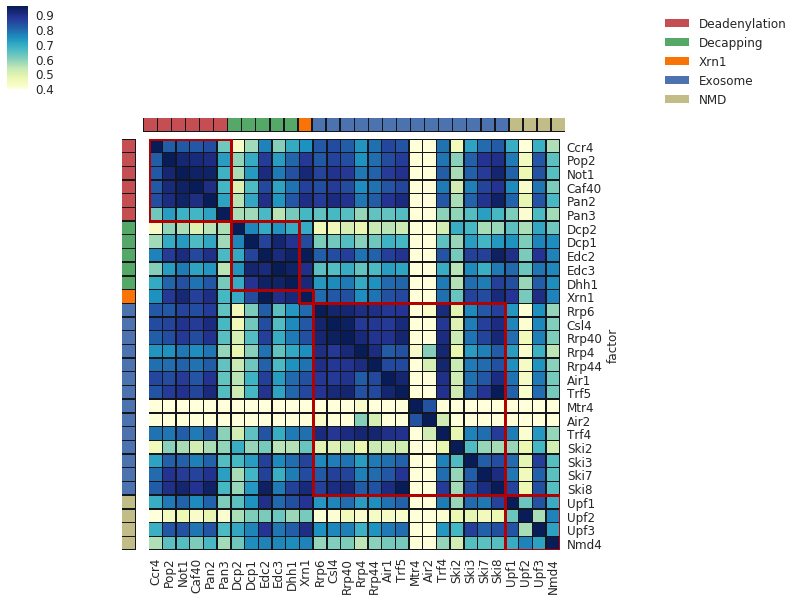

In [11]:
plot_cooccupancy_heatmap(pearson_corr, colormap='YlGnBu', clustering=False, filename='co_occupancy.pdf', 
                         savefile=savefile, heatmapkws=dict(square=True, linewidths=0.4, linecolor='#15151c', vmin=0.4, vmax=0.95) , all_factors=False)

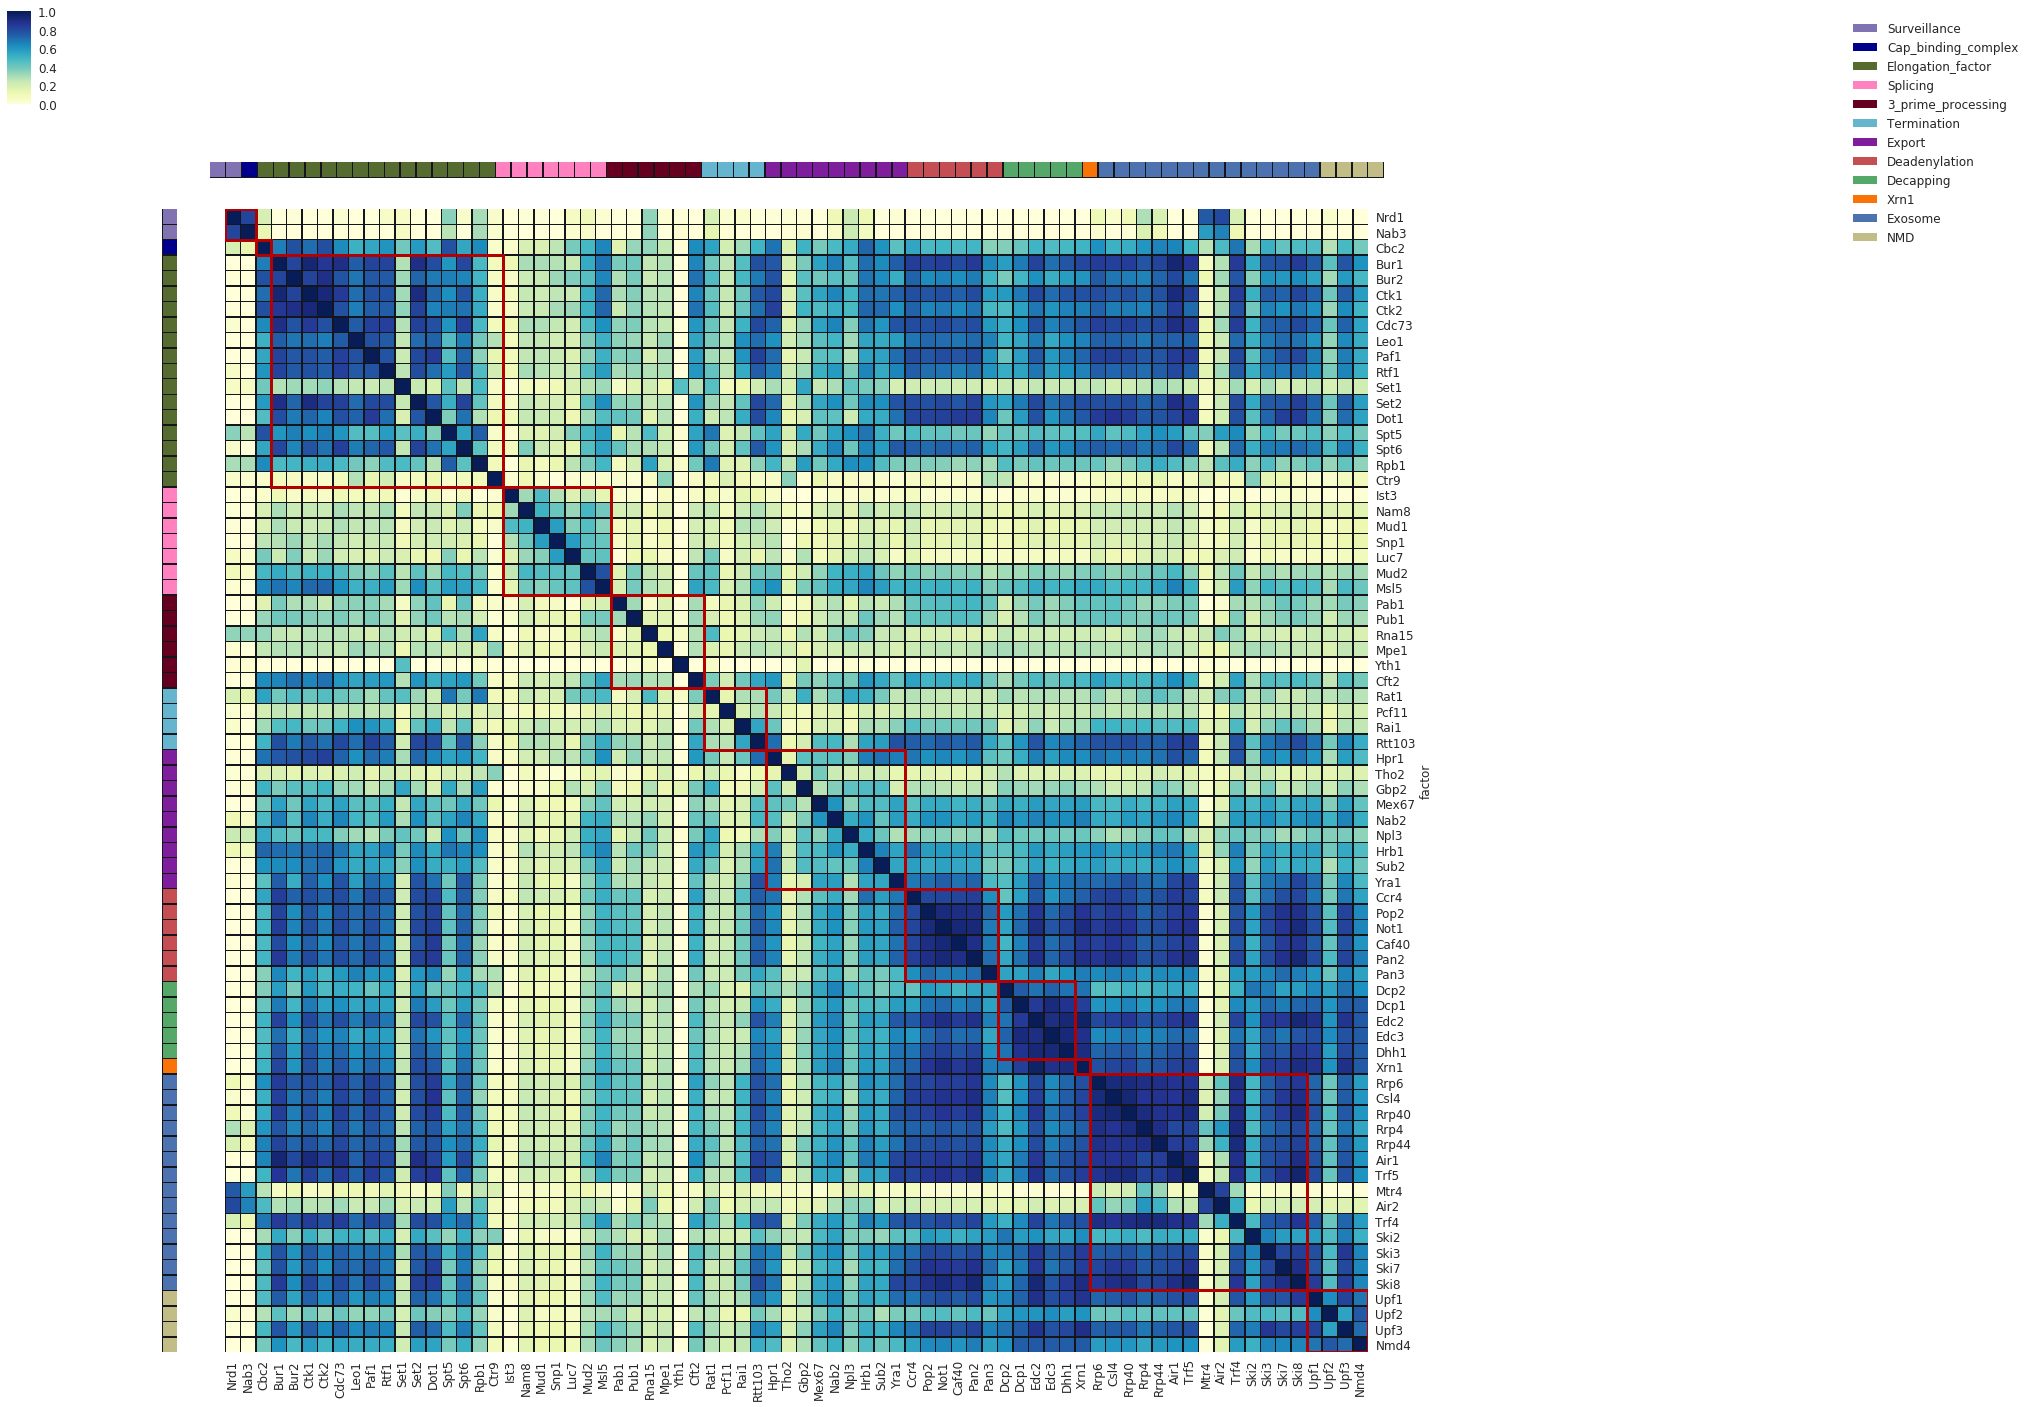

In [12]:
plot_cooccupancy_heatmap(pearson_corr, colormap='YlGnBu', clustering=False, filename='co_occupancy_all.pdf', 
                         savefile=savefile, heatmapkws=heatmapkws, all_factors=True)

### tSNE plots:
#### tSNE plots with randomly initialized variables have consistent topologies

In [13]:
colors = ['m', 'darkblue', 'darkolivegreen', 'xkcd:pink', 'xkcd:maroon', 'c', 'xkcd:purple', 'r', 'g', 'xkcd:orange', 'b', '#C2BC87']
factors = data_summary.factor
groups = data_summary.group
pathways = data_summary.pathway
g_names = data_summary.pathway.unique()
lut = dict(zip(pathways.unique(), colors))
pw_colors = [lut[x] for x in pathways]

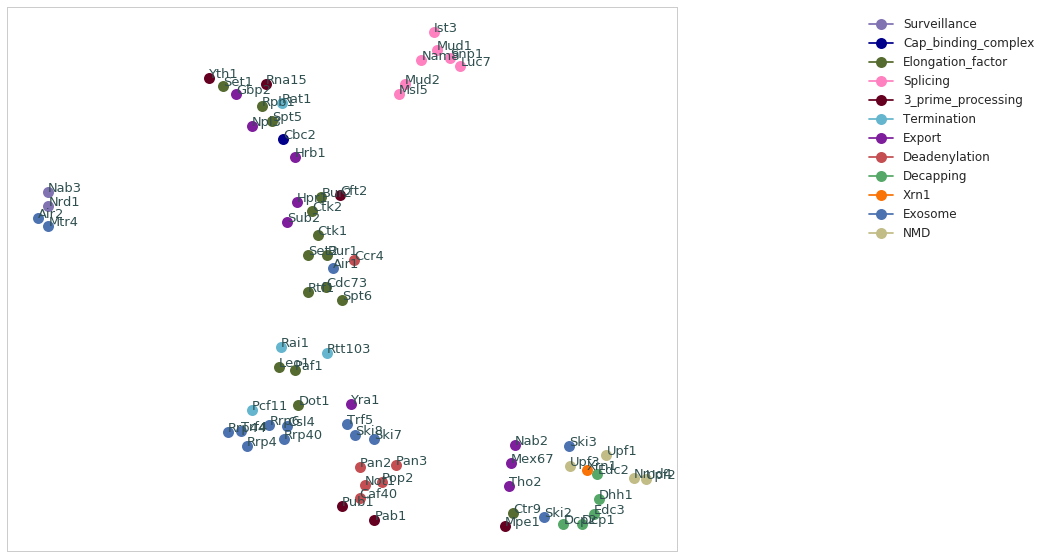

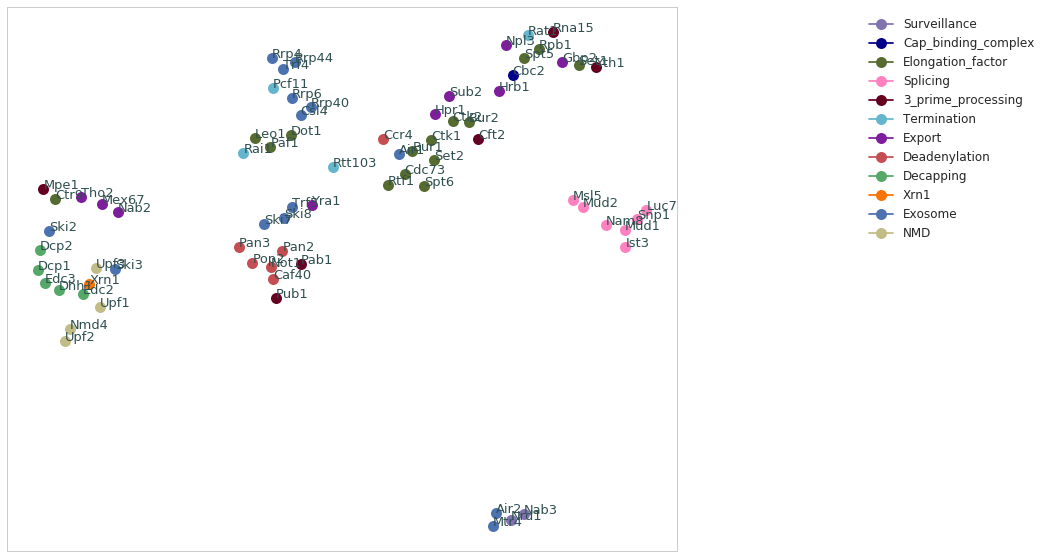

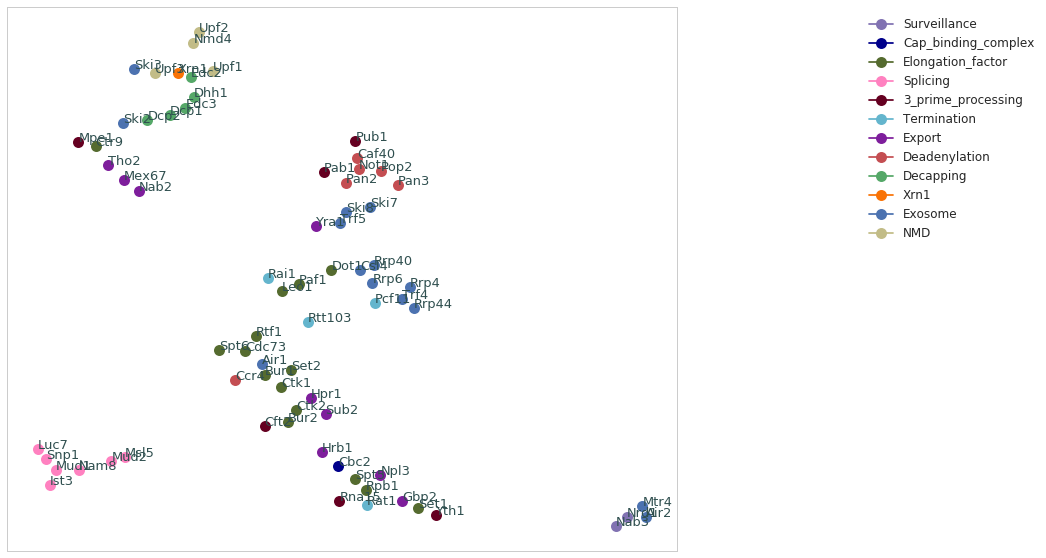

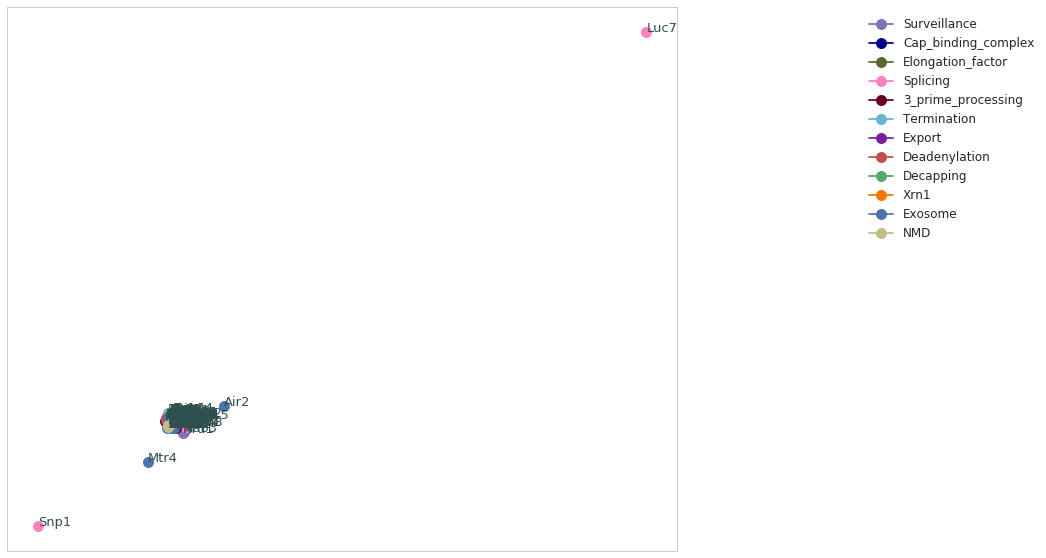

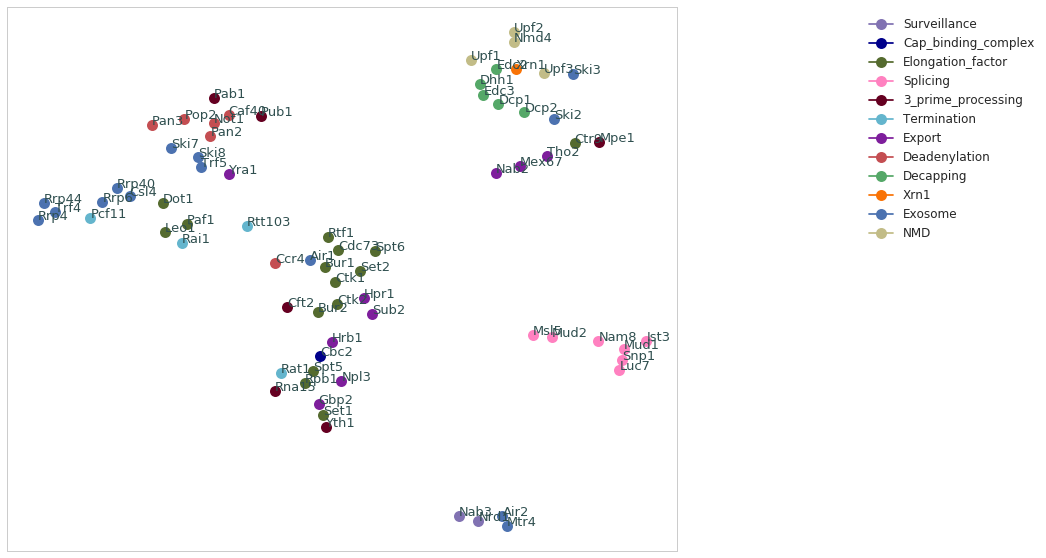

In [14]:
from sklearn.preprocessing import normalize
from sklearn import manifold

sns.set_style("whitegrid", {'axes.grid' : False})

for j in range(0, 5):
    
    np.random.seed(j)
    init=np.random.rand(len(factors),2)
    
    per=3.5
    
    model = manifold.TSNE(n_components=2, metric='precomputed', perplexity=per, n_iter = 8000, init=init)
    coords = model.fit_transform(1 - pearson_corr)

    fig, ax = plt.subplots(facecolor='w')
    fig.set_size_inches(12,10)

    for i, text in enumerate(factors):
        x = coords[i][0]
        y = coords[i][1]
        plt.plot(x, y, color = pw_colors[i],  marker='o', markersize=11, label=pathways[i])
        plt.text(x,y , text , fontsize=13, color='#2F4F4F')

    ax.xaxis.set_ticklabels([])   
    ax.yaxis.set_ticklabels([])
    lgd = ax.legend(bbox_to_anchor=(1.55, 1), loc=1)
    #plt.savefig(os.path.join(plotting_dir,'tSNE', 'tSNE_correlation_%d.pdf'%j), bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.close()